In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_NN(nn.Module):
    def __init__(self, K_no, L_no, H_no, T_no, device):
        super().__init__()
        
        self.K_no = K_no
        self.L_no = L_no
        self.H_no = H_no
        self.T_no = T_no
        self.device = device
        
        nn_list = []
        for l in range(self.L_no):
            if l == 0:
                nn_list.append(nn.Conv1d(in_channels=2, out_channels=H_no, kernel_size=K_no, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
            elif l == self.L_no - 1:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=1, kernel_size=1, padding=0))
            else:
                nn_list.append(nn.Conv1d(in_channels=H_no, out_channels=H_no, kernel_size=1, padding=0))
                #nn_list.append(nn.Tanh())
                nn_list.append(nn.LeakyReLU())
        
        self.nn = nn.Sequential(*nn_list)
        
    def forward(self, V, D):
        #V, D, S is shape (batch, 50000)
        
        input_pad = torch.zeros(V.shape[0], 2, V.shape[1] + self.K_no-1).to(self.device)
        input_pad[:,0,-V.shape[1]:] = input_pad[:,0,-V.shape[1]:] + V
        input_pad[:,1,-D.shape[1]:] = input_pad[:,1,-D.shape[1]:] + D
        
        nn_out = self.nn(input_pad).squeeze(1) # (batch, 50000)
        P = torch.sigmoid(nn_out)
        S = torch.bernoulli(P)
        return S, P



In [3]:
batch_size = 5
batch_length = 50000
K_no = 1
L_no = 2
H_no = 20
T_no = 501
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
D = V.copy()
D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_NN(K_no, L_no, H_no, T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

81


In [ ]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model(batch_V, batch_D)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%250 == 249) or (i == 0):
        model.eval()
        test_S_out, P_test = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-a095aa4c932e>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/39200 [00:00<?, ?it/s]

0 0.724750280380249 0.20505642890930176
249 0.2689262926578522 0.0026025772094726562
499 0.1184118315577507 0.002927541732788086
749 0.06222766265273094 0.0028693675994873047
999 0.037951692938804626 0.002442598342895508
1249 0.026199467480182648 0.002355813980102539
1499 0.019959891214966774 0.0023162364959716797
1749 0.016347937285900116 0.0024194717407226562
1999 0.014089120551943779 0.0022077560424804688
2249 0.012541597709059715 0.002367258071899414
2499 0.011372988112270832 0.0023412704467773438
2749 0.010396391153335571 0.002353191375732422
2999 0.009498334489762783 0.0025475025177001953
3249 0.008648067712783813 0.0025124549865722656
3499 0.007790275849401951 0.002420186996459961
3749 0.00692072743549943 0.0024003982543945312
3999 0.005706902127712965 0.0023827552795410156
4249 0.004753936547785997 0.0023593902587890625
4499 0.004240795038640499 0.0023941993713378906
4749 0.0039323014207184315 0.002393484115600586
4999 0.003739439882338047 0.0024356842041015625
5249 0.003616331

In [7]:
# 2649 0.004261615686118603 (true_na with refractory)
# 31249 0.0029351413249969482  (true_na without refractory)
# 35499 0.0030055860988795757  (comb_pred without refractory)
# 29749 0.003061493393033743  (whole_pred without refractory)


# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

tensor(0.0539, device='cuda:0', grad_fn=<MaxBackward1>)


(0.0, 0.25)

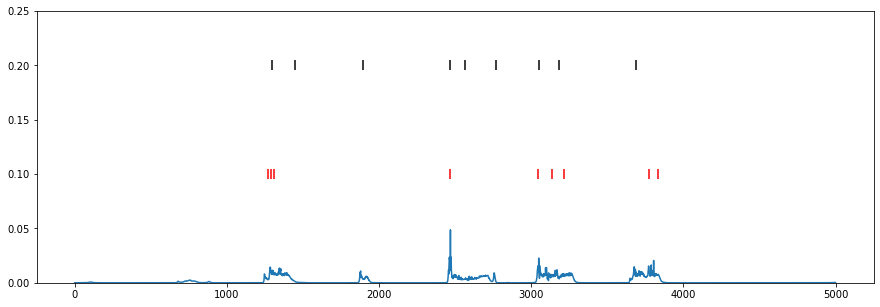

In [7]:
plt.figure(figsize = (15,5))
plt.plot(P_test[0][10000:15000].cpu().detach().numpy()[:])
plt.scatter(np.arange(5000), S_test[0][12000:32000][10000:15000].cpu().detach().numpy()-0.8, s=100, color="black", marker="|")
plt.scatter(np.arange(5000), test_S_out[0][10000:15000].cpu().detach().numpy()*0.9-0.8, s=100, color="red", marker="|")
print(torch.max(P_test))
plt.ylim(0,0.25)